In [1]:
import pickle
import numpy as np
import warnings
from scipy.stats import gaussian_kde
import seaborn as sns
from scipy.interpolate import InterpolatedUnivariateSpline, UnivariateSpline
from settings import *
from tools import get_mids

Could not import healpy.
functions plot_area, add_catalog, and add_extended_plane will not work.


In [2]:
matplotlib = sns.mpl
plt = matplotlib.pyplot
plt.style.use("../style.mplstyle")
colorlist = plt.rcParams["axes.prop_cycle"].by_key()["color"]
warnings.filterwarnings("ignore")

In [3]:
# use only upgoing data to mimick up-going muon track data set
with open("../resources/tabulated_logE_sindec_aeff_upgoing.pckl", "rb") as f:
    logE_bins, _, _ = pickle.load(f)

logE_mids = get_mids(logE_bins)

In [4]:
# Calculate energy smearing
# this takes a couple of seconds
public_data_hist = np.genfromtxt(
    "../resources/IC86_II_smearing.csv", skip_header=1
)

log_sm_emids = (public_data_hist[:, 0] + public_data_hist[:, 1]) / 2.0
log_sm_ereco_mids = (public_data_hist[:, 4] + public_data_hist[:, 5]) / 2.0
fractional_event_counts = public_data_hist[:, 10]

e_ereco_kdes = gaussian_kde(
    (log_sm_emids, log_sm_ereco_mids), weights=fractional_event_counts
)

# Original smearing matrix

In [5]:
logE_reco_bins = np.arange(0.5, 9, 0.05)
logE_reco_mids = get_mids(logE_reco_bins)
ee, rr = np.meshgrid(logE_mids, logE_reco_mids)


normed_kvals = e_ereco_kdes([ee.flatten(), rr.flatten()]).reshape(len(logE_reco_mids), len(logE_mids))
normed_kvals /= np.sum(normed_kvals, axis=0)
# logE_mids are the same as for effective area binning

plt.grid(False)
plt.pcolormesh(ee, rr, normed_kvals)
plt.colorbar()
plt.plot([1, 9], [1, 9], color="tab:orange")
plt.ylim(np.min(rr), np.max(rr))
plt.xlim(np.min(ee), np.max(ee))
plt.title("KDE reproduction of E-smearing")
plt.ylabel("log(E reco (muon) / GeV)")
plt.xlabel("log(E true (neutrino) / GeV)")

# Improved smearing matrix

In [7]:
logE_reco_bins = np.arange(0.5, 9, 0.05)
logE_reco_mids = get_mids(logE_reco_bins)
ee, rr = np.meshgrid(logE_mids, logE_reco_mids)


In [60]:
logE_reco_mode = []
kv_mode = []
kv_sigma = []
# find the mode of E-reco distribution in each slice of E-true
for ii, et in enumerate(logE_mids):
    max_ind = np.argmax(normed_kvals[:, ii])
    logE_reco_mode.append(logE_reco_mids[max_ind])
    kv_mode.append(normed_kvals[max_ind, ii])

    sigma_val = kv_mode[-1] / np.sqrt(np.e)
    # above mode
    mask = logE_reco_mids > logE_reco_mode[ii]
    # kval below sigma
    mask &= normed_kvals[:, ii] <= sigma_val
    tmp = np.interp(
        sigma_val,
        [normed_kvals[:, ii][~mask][-1], normed_kvals[:, ii][mask][0]],
        [logE_reco_mids[~mask][-1], logE_reco_mids[mask][0]],
    )

    kv_sigma.append(tmp - logE_reco_mode[-1])

# Interpolate the E-reco peak position and width
#e_spline = InterpolatedUnivariateSpline(logE_mids, logE_reco_mode)
e_spline = UnivariateSpline(logE_mids, logE_reco_mode, s=0.01)
sig_spline = UnivariateSpline(logE_mids, kv_sigma, s=0.1, k=1)


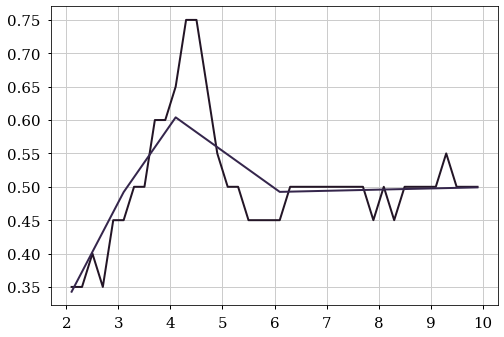

In [61]:
plt.plot(logE_mids, kv_sigma)
plt.plot(logE_mids, sig_spline(logE_mids))


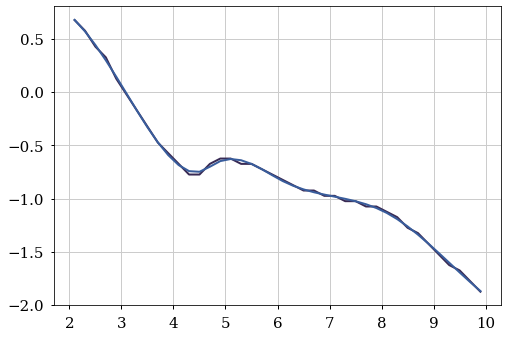

In [10]:
plt.plot(logE_mids, logE_reco_mode - logE_mids)
plt.plot(logE_mids, e_spline(logE_mids) - logE_mids)

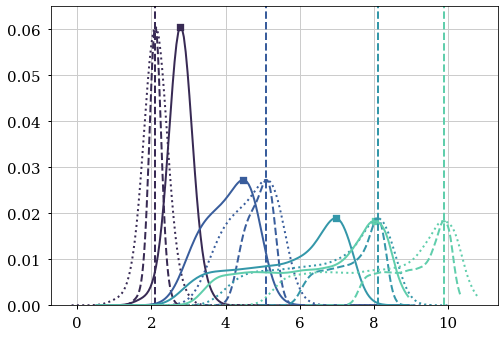

In [11]:
for i in np.concatenate([np.arange(0, len(logE_reco_mode), step=15), [-1]]):
    # for i in np.arange(0, len(logE_reco_mode)):
    p = plt.plot(logE_reco_mids, normed_kvals[:, i])
    plt.plot(
        (logE_reco_mids  - e_spline(logE_mids[i])) / 2 + logE_mids[i],
        normed_kvals[:, i],
        ls="--",
        color=p[0].get_color(),
    )
    plt.plot(
        logE_reco_mids + (logE_mids[i] - e_spline(logE_mids[i])),
        normed_kvals[:, i],
        ls=":",
        color=p[0].get_color(),
    )

    plt.scatter(logE_reco_mode[i], kv_mode[i], color=p[0].get_color(), marker="s")
    plt.axvline(logE_mids[i], color=p[0].get_color(), ls="--")
    # plt.axvline(logE_reco_mode[i], color=p[0].get_color())

    plt.ylim(0, 0.065)


In [12]:
sns.set_palette("mako", n_colors=10)

In [14]:
from scipy.stats import norm

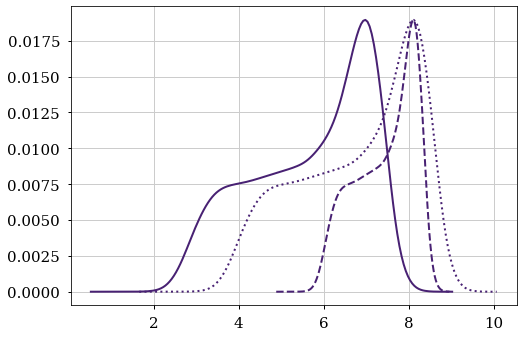

In [187]:
i = 30

p = plt.plot(logE_reco_mids, normed_kvals[:, i])
plt.plot(
    (logE_reco_mids  - e_spline(logE_mids[i])) / 2 + logE_mids[i],
    normed_kvals[:, i],
    ls="--",
    color=p[0].get_color(),
)
plt.plot(
    logE_reco_mids + (logE_mids[i] - e_spline(logE_mids[i])),
    normed_kvals[:, i],
   ls=":",
     color=p[0].get_color(),
 )

# plt.scatter(logE_reco_mode[i], kv_mode[i], color=p[0].get_color(), marker="s")
# plt.axvline(logE_mids[i], color=p[0].get_color(), ls="--")
# plt.axvline(logE_reco_mode[i], color=p[0].get_color())

# plt.ylim(0, 0.065)


In [89]:
logE_reco_bins = np.arange(0.5, 9, 0.2)
logE_reco_mids = get_mids(logE_reco_bins)
ee, rr = np.meshgrid(logE_mids, logE_reco_mids)
# shift the KDE evaluation by the difference between expected E peak and the actual E-reco peak
# rr_shifted = (rr - logE_mids) * 1.2 + e_spline(logE_mids)
rr_shifted = rr - (logE_mids - e_spline(logE_mids))

ideal_normed_kvals = e_ereco_kdes([ee.flatten(), rr_shifted.flatten()]).reshape(len(logE_reco_mids), len(logE_mids))
ideal_normed_kvals /= np.sum(ideal_normed_kvals, axis=0)

Text(0.5, 0, 'log(E true (neutrino) / GeV)')

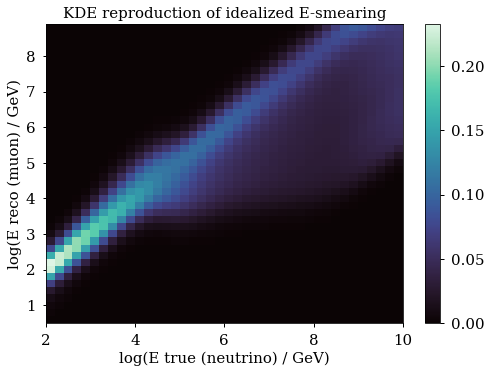

In [90]:
## result
plt.grid(False)
plt.pcolormesh(ee, rr, ideal_normed_kvals)
plt.colorbar()
#plt.ylim(1, 8.8)
#plt.xlim(2, 9)
#plt.plot([2, 10], [2, 10], color="tab:orange", lw=1)
plt.title("KDE reproduction of idealized E-smearing")
plt.ylabel("log(E reco (muon) / GeV)")
plt.xlabel("log(E true (neutrino) / GeV)")

In [102]:
with open("../resources/improved_energy_smearing_kde.pckl", "wb") as f:
    pickle.dump((ideal_normed_kvals, logE_reco_bins), f)

# Artificial smearing matrix

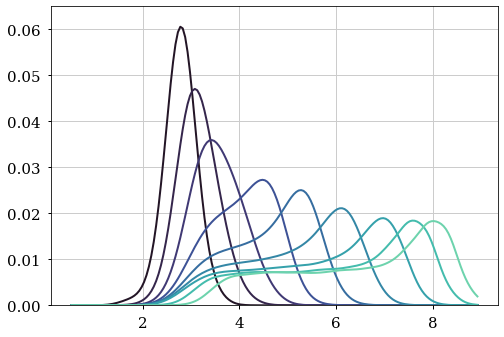

In [15]:
## as reference:
for i in np.concatenate([np.arange(0, len(logE_reco_mode), step=5), [-1]]):
    # for i in np.arange(0, len(logE_reco_mode)):
    p = plt.plot(logE_reco_mids, normed_kvals[:, i])
    plt.ylim(0, 0.065)


In [16]:
from scipy.special import erf

In [17]:
def double_erf(x, shift_l, shift_r, sigma):
    # normalized such that ig goes from 0 to 1 and back to 0
    return (erf((x - shift_l) / sigma) + 1) * (-erf((x - shift_r) / sigma) + 1) / 4

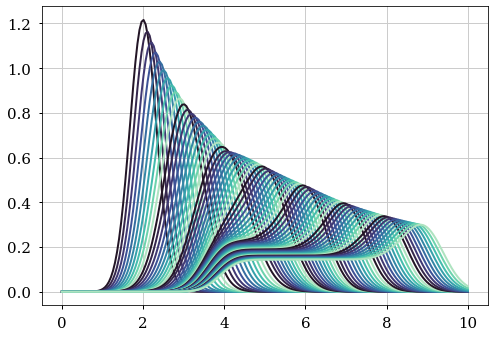

In [87]:
# testing
art_logE_reco = np.linspace(0, 10, 200)
art_logE_true = np.arange(2, 9, step=0.1)
dx = art_logE_reco[1] - art_logE_reco[0]
artificial_2D = []

plt.figure()
# for etrue in art_logE_true:
#     mu_N = e_spline(etrue)
for mu_N in art_logE_true:
    shift_l = 3. + 0.1 * mu_N
    sigma_S = sigma_N = sig_spline(mu_N)
    shift_r = mu_N - sigma_S

    # siggi /= np.sum(siggi * (x[1] - x[0]))  # normalize
    norbert = norm.pdf(art_logE_reco, loc=mu_N, scale=sigma_N)
    siggi = double_erf(art_logE_reco, shift_l, shift_r, sigma_S)
    siggi *= norm.pdf(mu_N, loc=mu_N, scale=sigma_N) / 2  # normalize

    combined = siggi + norbert
    combined /= np.sum(combined * dx)  # normalize
    plt.plot(art_logE_reco, combined)
    artificial_2D.append(combined)
artificial_2D = np.array(artificial_2D)


Text(0.5, 0, 'log(E true (neutrino) / GeV)')

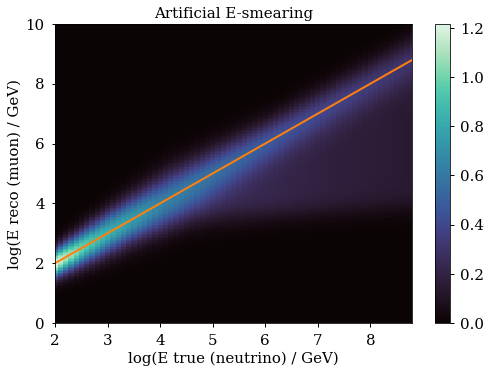

In [88]:
plt.figure()
aee, arr = np.meshgrid(art_logE_true, art_logE_reco)
plt.pcolormesh(aee, arr, artificial_2D.T)
plt.ylim(0, 10)
plt.xlim(2, 8.8)
plt.plot([1, 9], [1, 9], color="tab:orange")
plt.colorbar()
plt.title("Artificial E-smearing")
plt.ylabel("log(E reco (muon) / GeV)")
plt.xlabel("log(E true (neutrino) / GeV)")


Text(0.5, 0, 'log(E true (neutrino) / GeV)')

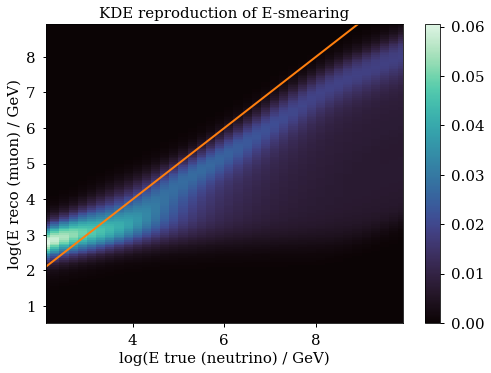

In [79]:
logE_reco_bins = np.arange(0.5, 9, 0.05)
logE_reco_mids = get_mids(logE_reco_bins)
ee, rr = np.meshgrid(logE_mids, logE_reco_mids)


normed_kvals = e_ereco_kdes([ee.flatten(), rr.flatten()]).reshape(len(logE_reco_mids), len(logE_mids))
normed_kvals /= np.sum(normed_kvals, axis=0)
# logE_mids are the same as for effective area binning

plt.grid(False)
plt.pcolormesh(ee, rr, normed_kvals)
plt.colorbar()
plt.plot([1, 9], [1, 9], color="tab:orange")
plt.ylim(np.min(rr), np.max(rr))
plt.xlim(np.min(ee), np.max(ee))
plt.title("KDE reproduction of E-smearing")
plt.ylabel("log(E reco (muon) / GeV)")
plt.xlabel("log(E true (neutrino) / GeV)")